In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import pickle

2024-04-18 13:48:22.159737: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 13:48:25.125523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 13:48:49.669064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
num_classes = 22
latent_dim = 10
num_channels = 3
generator_channels = latent_dim + num_classes
discriminator_channels = num_classes + num_channels
batch_size = 64
image_size = 256

In [4]:
def load_data(batch_size=batch_size):
    train_data = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    test_data = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=(256,256),
                                                            batch_size=batch_size)
    return train_data, test_data

In [5]:
train_data, test_data = load_data()

Found 3300 files belonging to 22 classes.


2024-04-18 13:49:25.043005: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:31:00.0, compute capability: 8.0


Found 3298 files belonging to 22 classes.


In [23]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((256, 256, discriminator_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_channels,)),
        layers.Dense(4 * 4 * generator_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((4, 4, generator_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [7]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [8]:
np.random.seed(4352)
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [24]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 8, 8, 128)      │        65,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 128, 128, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 256, 256, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,415,811 (5.40 MB)

 Trainable params: 1,414,275 (5.40 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [10]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,449 (345.50 KB)

 Trainable params: 88,449 (345.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = cond_gan.fit(train_data, epochs=10)

Epoch 1/30


I0000 00:00:1713462615.186104  980111 service.cc:145] XLA service 0x7f94d803de80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713462615.188326  980111 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-04-18 13:50:15.363738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-18 13:50:16.674336: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-18 13:50:24.303169: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,128,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,32,32]{3,2,1,0}, f32[128,128,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0",

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - d_loss: 2.7544 - g_loss: 2.1189

2024-04-18 13:53:09.976254: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[36,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,128,64,64]{3,2,1,0}, f32[128,128,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-18 13:53:11.480653: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.51311104s
Trying algorithm eng0{} for conv (f32[36,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[36,128,64,64]{3,2,1,0}, f32[128,128,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operatio

52/52 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - d_loss: 2.7139 - g_loss: 2.1480 - discriminator_loss: 0.6494 - generator_loss: 3.6318
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - d_loss: 7.6753e-04 - g_loss: 6.5465 - discriminator_loss: 6.0490e-04 - generator_loss: 6.7831
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - d_loss: 3.5348e-04 - g_loss: 7.2802 - discriminator_loss: 3.1350e-04 - generator_loss: 7.4036
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - d_loss: 2.2095e-04 - g_loss: 7.7460 - discriminator_loss: 2.0029e-04 - generator_loss: 7.8465
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - d_loss: 1.5035e-04 - g_loss: 8.1282 - discriminator_loss: 1.3851e-04 - generator_loss: 8.2122
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 467ms/step - d_loss: 1.0931e-04 - g_loss: 8.4459 - discriminator_loss: 1.0198e-04 - generator_loss: 8.5162
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 466ms/step - d_loss: 1.0044e-04 - g_loss: 8.5324 - discriminator_loss: 9.6675e-05 - g

KeyboardInterrupt: 

NameError: name 'history' is not defined

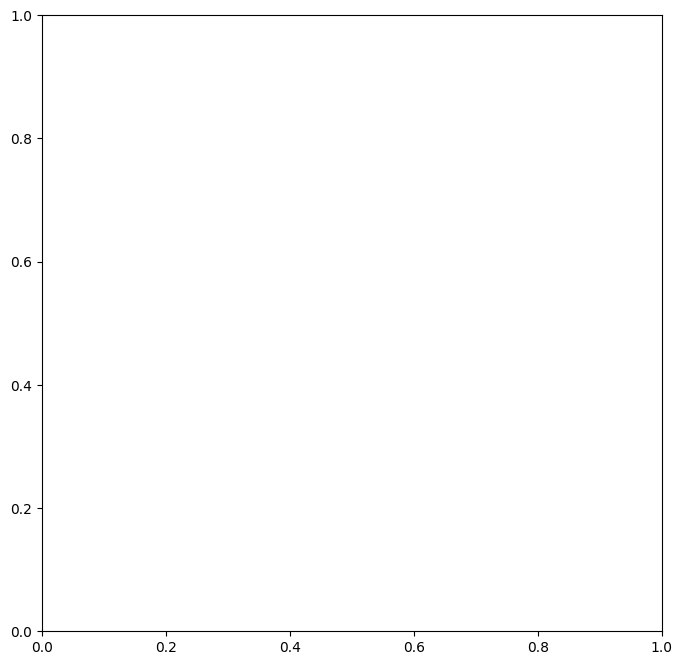

In [12]:
import matplotlib.pyplot as plt    
_, ax = plt.subplots(figsize=(8,8))
ax.plot(history.epoch, history.history['discriminator_loss'], label='Discriminator')
ax.plot(history.epoch, history.history['generator_loss'], label='Generator')
ax.set_title('Discriminator and generator loss vs. epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend()

In [39]:
noise = keras.random.normal(shape=(1,latent_dim))
noise = ops.repeat(noise, repeats=num_classes)
noise = ops.reshape(noise, (num_classes, latent_dim))

labels = np.arange(num_classes)
labels = keras.utils.to_categorical(labels, num_classes)
noise_and_labels = ops.concatenate([noise, labels], axis=1)

In [40]:
trained_gen = cond_gan.generator
fake = trained_gen.predict(noise_and_labels)

2024-04-18 13:26:24.966168: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[22,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,128,64,64]{3,2,1,0}, f32[128,128,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-04-18 13:26:25.468580: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.518539788s
Trying algorithm eng0{} for conv (f32[22,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,128,64,64]{3,2,1,0}, f32[128,128,4,4]{3,2,1,0}), window={size=4x4 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operati

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step


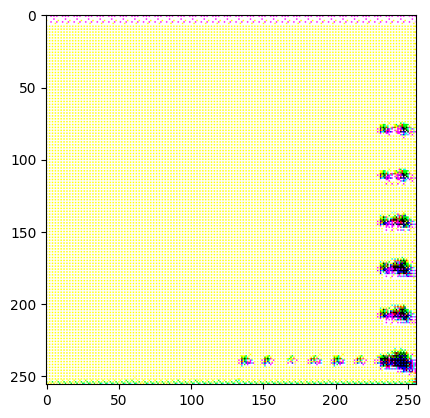

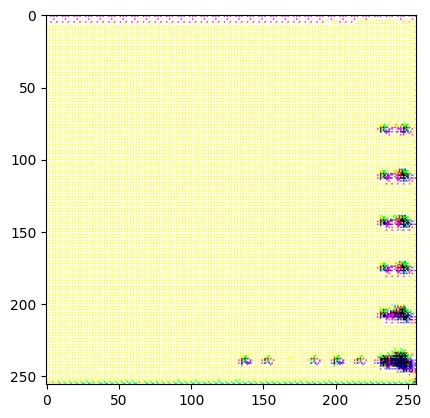

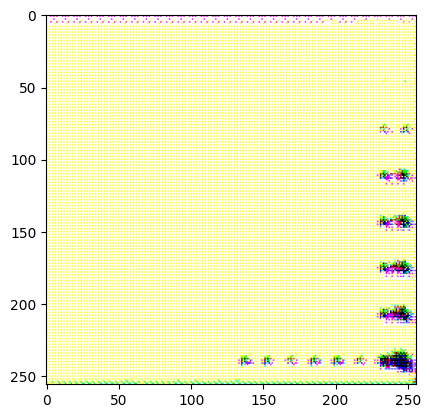

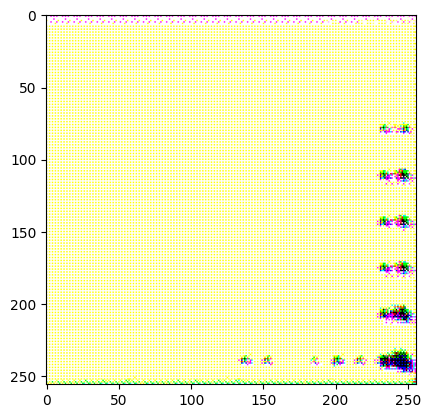

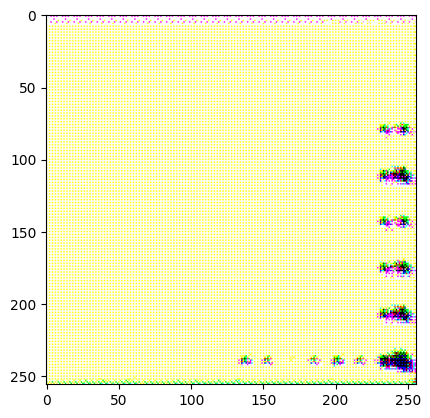

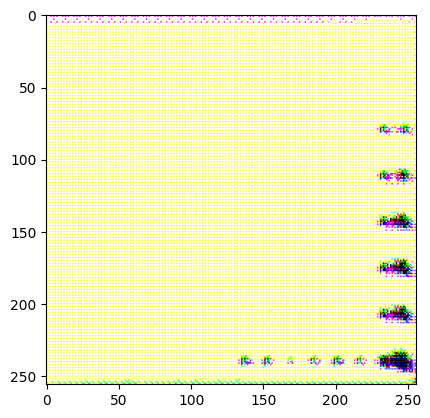

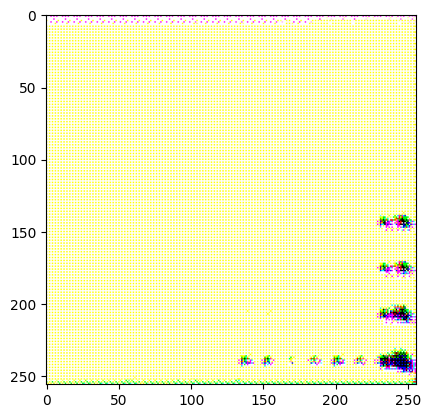

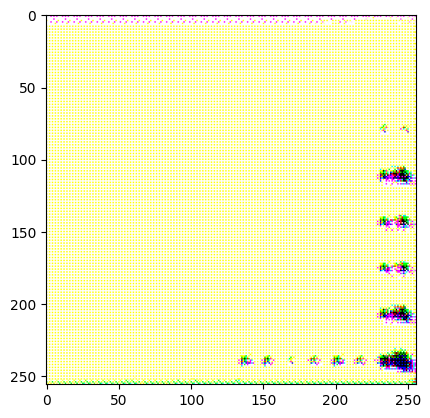

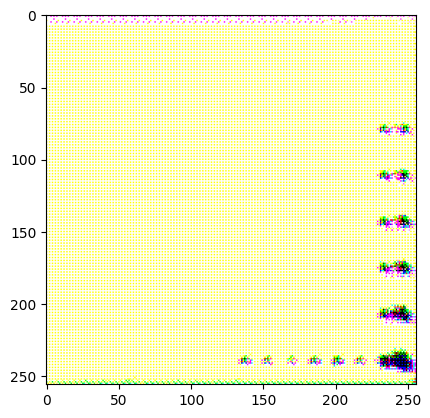

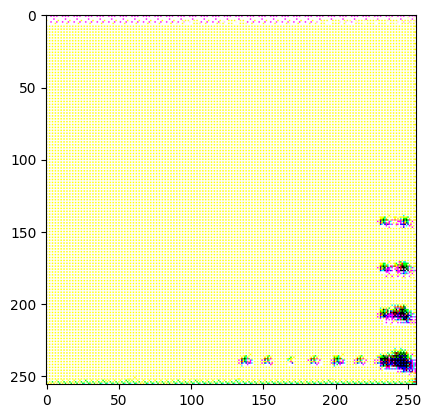

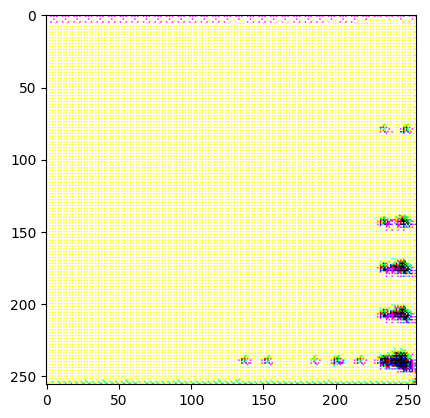

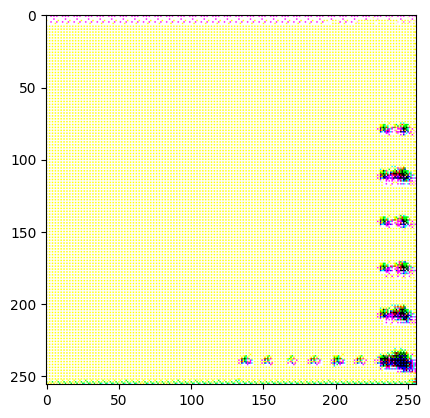

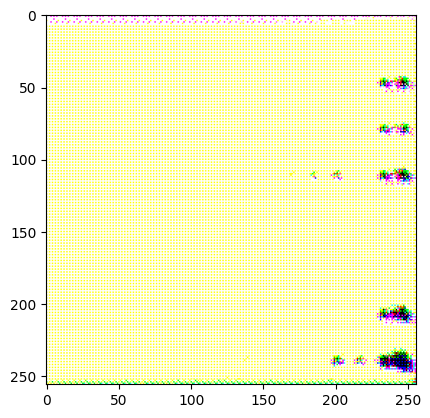

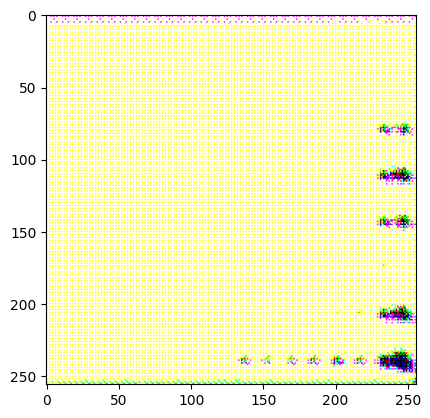

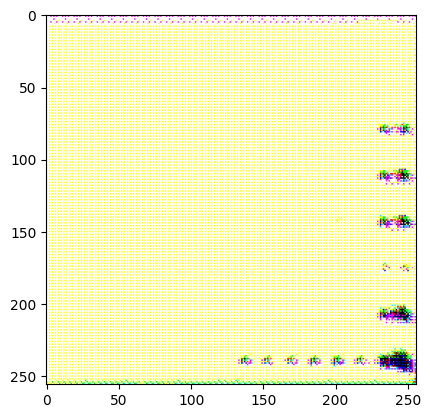

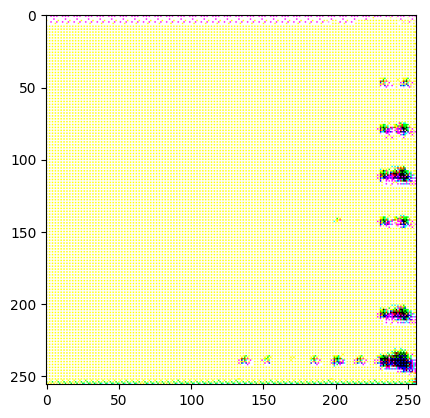

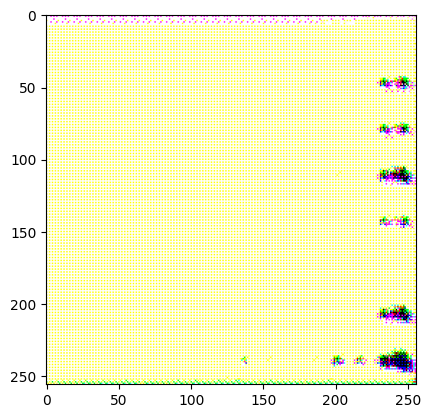

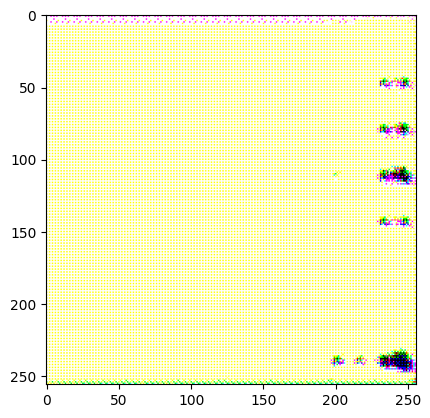

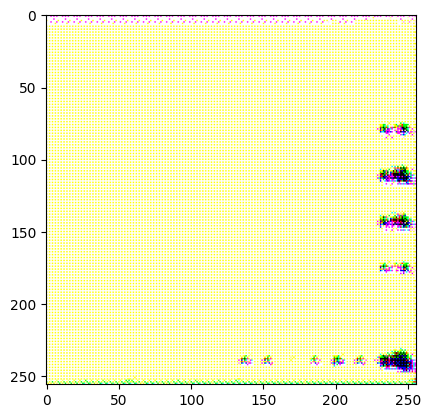

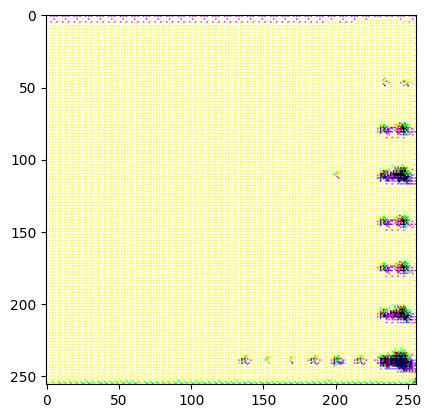

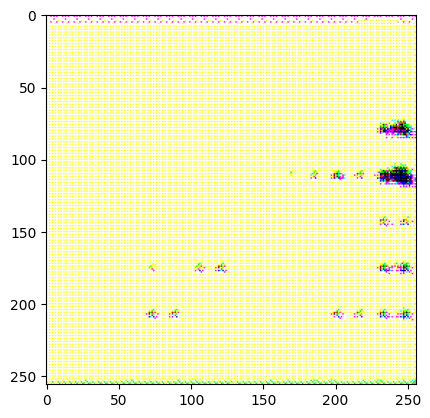

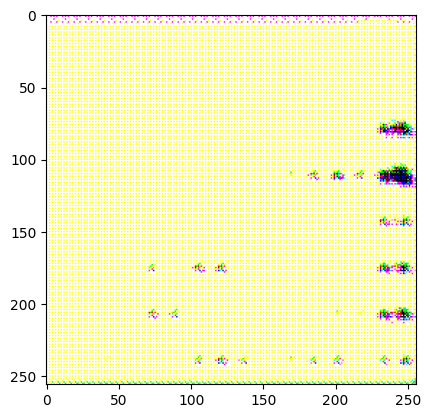

In [43]:
for image in fake:
    plt.imshow(image)
    plt.show()